In [1]:
import sys
import os
import glob
import json
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np

In [2]:
def find_files(path):
    return glob.glob(path)

In [3]:
def read_json(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

### Az adathalmaz letöltése

In [4]:
from torchtext.utils import download_from_url, extract_archive

dataset_tar = download_from_url('https://drive.google.com/uc?id=1k7GfVRqrHFK00ABkit0oGQo62fCakMSZ', root='.data/')
extracted_files = extract_archive(dataset_tar)

## Adatok olvasása
Adatok beolvasása JSON fájlként, majd egy nagy pandas-os DataFrame-mé alakítása.

In [5]:
json_data = []

for file in find_files('.data/gyakori_*'):
    print("Reading file:", file)
    json_data.append(read_json(file))
    
data_frame = pd.DataFrame()

for data in json_data:
    frames  = [data_frame, pd.DataFrame(data)]
    data_frame = pd.concat(frames).reset_index(drop=True)

Reading file: .data/gyakori_szamitastechnika
Reading file: .data/gyakori_egeszseg
Reading file: .data/gyakori_egeszseg_20000
Reading file: .data/gyakori_allatok_14000
Reading file: .data/gyakori_szorakozas_30000


## Bepillantás a kérdésekbe
Csak hogy tudjuk pontosan mivel is állunk szemben. Minden kérdéshez tartozik a kérdés rövid, illetve hosszú verziója, egy válasz, amit a felhasználók a leghasznosabbnak találtak. Ezeken kívül kategóriák és kulcsszavak is vannak a kérdéshez.

In [6]:
data_frame.head(2)

,valasz,kategoriak,hosszu_kerdes,rovid_kerdes,keywords
0,Várak régen is voltak. Ha mindhárom tornyot le...,"[Számítástechnika, Internet]",Miért lett ilyen sz@r a honfoglaló? Régen tök ...,Miért lett ilyen sz@r a honfoglaló?,"[Honfoglaló, vár]"
1,"Ahogy írták, az stdio az a C-s függvénykönyvtá...","[Számítástechnika, Programozás]",C++-ban melyiket érdemesebb használni? Stdio v...,C++-ban melyiket érdemesebb használni? Stdio v...,"[C++, iostream, konzol, Windows, Visual Studio]"


### Túl kicsi kategóriák szűrése
Ha egy kategóriához túl kevés kérdés tartozik, akkor nem érdemes a továbbiakban foglalkozni vele. A túl kicsi kategóriák szűrése következik.

In [7]:
target_names = data_frame['kategoriak'].apply(lambda x: x[0]).unique().tolist()

minimum_questions_for_each_category = 3000

for target in target_names:
    target_size = data_frame[data_frame['kategoriak'].apply(lambda x : x[0]) == target].shape[0]
    if target_size < minimum_questions_for_each_category:
        data_frame = data_frame[data_frame['kategoriak'].apply(lambda x : x[0]) != target]


### Túl rövid kérdések szűrése
A túl rövid kérdések nem túl hasznosak. Az adathalmazban előfordul pár 2 szóból álló HOSSZÚ kérdés. Vegyük például a következő kérdéseket: `Militaryra appalosa?`, `Ivabradine vélemények?`. Ezek a kérdések nem meghatározóak a témájukra nézve.

In [8]:
minimum_words_per_question = 5
data_frame = data_frame[data_frame['hosszu_kerdes'].apply(lambda x: len(x.split())) >= minimum_words_per_question]

## "Főkategóriák" kigyűjtése
Az egyes főkategóriák neveinek kigyűjtése, majd az egyes nevekhez egy azonosító szám rendelése.

In [9]:
def get_target_names(idx, data_frame):
    target_names = data_frame['kategoriak'].apply(lambda x: x[idx]).unique().tolist()
    target_dict =  {value: key for key, value in enumerate(target_names)}
    
    return target_names, target_dict, len(target_names)

In [10]:
target_names, target_dict, num_of_categories = get_target_names(0, data_frame)

print(target_names)
print(target_dict)
print("Kategóriák száma: ", num_of_categories)

['Számítástechnika', 'Egészség', 'Állatok', 'Szórakozás']
{'Számítástechnika': 0, 'Egészség': 1, 'Állatok': 2, 'Szórakozás': 3}
Kategóriák száma:  4


## Tanító adathalmaz előállítása
A tanító adathalmazban minden egyes főkategóriából ugyanannyi kérdésnek kell szerepelnie (így fair). Itt pontosan ez történik `questions_from_each_category` darab kérdés kerül a tanító adathalmazba minden kategóriából, majd az eredményül kapott tömb véletlenszerűen összekeveredik.

#### Shuffle together
A shuffle_together függvény két listát véletlenszerűen kever össze, úgy, hogy az a keverés előtt az egyes listákban azonos indexen szereplő értékek a keverés után is azonos indexen lesznek.

In [11]:
import random

def shuffle_together(list1, list2):
    zipped = list(zip(list1, list2))
    random.shuffle(zipped)
    list1, list2 = zip(*zipped)
    
    return (list(list1), list(list2))

#### Least questions in category
Ez a találó nevű függvény azt akarja kiszámolni, hogy a legkevesebb kérdéssel rendelkező kategóriában mennyi kérdés van. Ezt azért számolom ki, hogy a tanító és tesztelő adathalmazokba ugyanannyi kérdés kerülhessen minden kategóriába.


In [12]:
def least_questions_in_ctg(idx, target_names, data_frame):
    min_amount = float('inf')

    for target_name in target_names:
        amount = len(data_frame[data_frame["kategoriak"].apply(lambda x : x[idx]) == target_name]['kategoriak'])
        min_amount = min(amount, min_amount)
    return min_amount

#### Split datasets

In [13]:
def split_datasets(train_ratio, questions_size, ctg_idx, data_frame, num_of_categories, target_names, target_dict):
    
    train_each_ctg = int(train_ratio * questions_size)
    train_size = train_each_ctg * num_of_categories
    train_questions = []
    train_target = []
    
    test_each_ctg = int((1.0 - train_ratio) * questions_size)
    test_size = test_each_ctg * num_of_categories
    test_questions = []
    test_target = []
    
    for target_name in target_names:
        train_questions += data_frame[data_frame["kategoriak"].apply(lambda x: x[ctg_idx]) == target_name][0:train_each_ctg]["hosszu_kerdes"].to_list()
        train_target += [target_dict[target_name]] * train_each_ctg    
    
        test_questions += data_frame[data_frame["kategoriak"].apply(lambda x: x[ctg_idx]) == target_name][train_each_ctg:train_each_ctg + test_each_ctg]["hosszu_kerdes"].to_list()
        test_target += [target_dict[target_name]] * test_each_ctg
    
    train_questions, train_target = shuffle_together(train_questions, train_target)
    test_questions, test_target = shuffle_together(test_questions, test_target)
    
    return train_each_ctg, train_size, train_questions, train_target,\
        test_each_ctg, test_size, test_questions, test_target

In [14]:
train_ratio = 0.80
test_ratio = 1.0 - train_ratio

min_amount = least_questions_in_ctg(0, target_names, data_frame)
train_each_ctg, train_size, train_questions, train_target, \
    test_each_ctg, test_size, test_questions, test_target = \
        split_datasets(train_ratio, min_amount, 0, data_frame, num_of_categories, target_names, target_dict)

In [15]:
import unidecode
import re

def unicode_to_ascii(data):
    return unidecode.unidecode(re.sub(r"[,.;@#?!&$]+\ *", " ", data).lower()).split()

#### Get vocab

In [16]:
def get_vocab(questions):
    vocab = set()
    
    for idx, question in enumerate(questions):
        words = unicode_to_ascii(question)

        for idx in range(len(words)):
            vocab.add(words[idx])

    vocab_size = len(vocab)

    index_to_word = {}

    for idx, word in enumerate(vocab):
        index_to_word[word] = idx
        
    return vocab, vocab_size, index_to_word

In [17]:
vocab, vocab_size, index_to_word = get_vocab(train_questions)

In [18]:
def get_batch(text, target, i, batch_size, input_size, index_to):

    batches = []
    results = []
    
    texts = text[i * batch_size : (i + 1) * batch_size]
    categories = target[i * batch_size : (i + 1) * batch_size]

    for text in texts:
        layer = np.zeros(input_size, dtype=float)
        words = unicode_to_ascii(text)
        
        for word in words:
            if word in index_to:
                layer[index_to[word]] += 1
            
        batches.append(layer)
        
    for category in categories:
        results.append(category)
     
    return np.array(batches), np.array(results)

In [19]:
learning_rate = 0.01
num_epochs = 2
batch_size = 200

hidden_size = 100
input_size = vocab_size
num_classes = len(target_names)

In [20]:
from torch.autograd import Variable
import torch.nn as nn
import torch

class BOWClassification(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(BOWClassification, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)
 
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

#### Get net

In [21]:
def get_net(vocab_size, hidden_size, num_classes, learning_rate, num_epochs, train_questions, train_target, batch_size, index_to_word):
    net = BOWClassification(vocab_size, hidden_size, num_classes)

    criterion = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  


    for epoch in range(num_epochs):
        if epoch:
            print()
        print("Epoch %d/%d: " % (epoch + 1, num_epochs))
        total_batch = len(train_questions) // batch_size
        for i in range(total_batch):
            batch_x, batch_y = get_batch(train_questions, train_target, i, batch_size, vocab_size, index_to_word)
            questions = Variable(torch.FloatTensor(batch_x))
            themes = Variable(torch.LongTensor(batch_y))

            optimizer.zero_grad()
            outputs = net(questions)
            loss = criterion(outputs, themes)
            loss.backward()
            optimizer.step()

            print("\r[%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")
    
    return net

In [22]:
net = get_net(vocab_size, hidden_size, num_classes, learning_rate, num_epochs, train_questions, train_target, batch_size, index_to_word)

Epoch 1/2: 
[373/373] 100.00%
Epoch 2/2: 
[373/373] 100.00%

In [23]:
def test_net(net, test_q, test_t, batch_s, vocab_s, index2word):
    total_batch = len(test_q) // batch_s

    total_pred = []

    for i in range(total_batch):
        test_batch_x, test_batch_y = get_batch(test_q, test_t, i, batch_s, vocab_s, index2word)
        print("\rTesting... [%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")

        questions = Variable(torch.FloatTensor(test_batch_x))
        themes = Variable(torch.FloatTensor(test_batch_y))

        outputs = net(questions)
        _, predicted = torch.max(outputs.data, 1)
        total_pred += predicted.tolist()
        
    return total_pred

In [24]:
total_predicted = test_net(net, test_questions, test_target, batch_size, vocab_size, index_to_word)

Testing... [93/93] 100.00%

## Tesztelés eredémye

### Confusion matrix
Tévesztési mátrix magyarul. A mátrix `i` sorában, `j` oszlopában szereplő érték (ebben az esetben) azt jelenti, hogy a mondat a `i` kategóriájú, de a háló `j` kategóriát ismert fel.

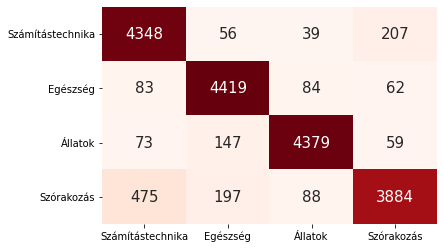

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_target[0:len(total_predicted)], total_predicted)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
plt.show()

## Classification report
#### Accuracy
A accuracy érték jelentése: a kérdések mekkora részét sikerült helyesen osztályozni.
#### Precision
A Szórakozás kategóriához tartozó precision érték azt jelenti, hogy az összes Szórakozás kategóriába sorolt kérdés közül mekkora arányban vannak a ténylegesen Szórakozás kategóriájú kérdések.
#### Recall
A recall érték a precision értékhez eléggé hasonló. Az összes ténylegesen Szórakozás kategóriájú kérdés mekkora részét sorolta Szórakozás kategóriába az osztályozó.

In [26]:
from sklearn.metrics import classification_report

class_report = classification_report(test_target[0:len(total_predicted)], total_predicted, target_names=target_names)
print(class_report)

                  precision    recall  f1-score   support

Számítástechnika       0.87      0.94      0.90      4650
        Egészség       0.92      0.95      0.93      4648
         Állatok       0.95      0.94      0.95      4658
      Szórakozás       0.92      0.84      0.88      4644

        accuracy                           0.92     18600
       macro avg       0.92      0.92      0.92     18600
    weighted avg       0.92      0.92      0.92     18600



## Alkategória osztályozás
A főkategória osztályozáshoz hasonló módszerrel próbálkozva. A 4 főkategóriát most elkülönítjük egymástól, 1 tanító adathalamzban csak 1 főkategóriához tartozó kérdések lesznek. Ennek megfelelően az eddig látott dolgokból 4 fog kelleni (háló, tévesztési mátrix, tanító-, tesztelő halmaz stb.)

#### Get target names

In [27]:
target_names_sub = {}
target_dict_sub = {}
num_of_ctg_sub = {}

filtered_df = {}

for t in target_names:
    filtered_df[t] = data_frame[data_frame['kategoriak'].apply(lambda x: x[0]) == t]
    filtered_df[t] = filtered_df[t][filtered_df[t]['kategoriak'].apply(lambda x: x[1]) != 'Egyéb kérdések']
    target_names_sub[t], target_dict_sub[t], num_of_ctg_sub[t] = get_target_names(1, filtered_df[t])


#### Split datasets

In [28]:
train_ratio = 0.8

min_amount_sub = {}

train_each_sub = {}
train_questions_sub = {}
train_size_sub = {}
train_target_sub = {}

test_each_sub = {}
test_questions_sub = {}
test_size_sub = {}
test_target_sub = {}

for t in target_names:
    min_amount_sub[t] = least_questions_in_ctg(1, target_names_sub[t], filtered_df[t])
    
    train_each_sub[t], train_size_sub[t], train_questions_sub[t], train_target_sub[t], \
        test_each_sub[t], test_size_sub[t], test_questions_sub[t], test_target_sub[t] = \
            split_datasets(train_ratio, min_amount_sub[t], 1, filtered_df[t], num_of_ctg_sub[t], target_names_sub[t], target_dict_sub[t])


#### Get vocab

In [29]:
vocab_sub = {}
vocab_size_sub = {}
index_to_word_sub = {}

for t in target_names:
    vocab_sub[t], vocab_size_sub[t], index_to_word_sub[t] = get_vocab(train_questions_sub[t])

In [30]:
learning_rate = 0.005
num_epochs = 2
batch_size = 75

hidden_size = 200

In [31]:
net_sub = {}

for t in target_names:
    print(t)
    net_sub[t] = get_net(vocab_size_sub[t], hidden_size, num_of_ctg_sub[t], learning_rate, num_epochs, train_questions_sub[t], train_target_sub[t], batch_size, index_to_word_sub[t])
    print()

Számítástechnika
Epoch 1/2: 
[49/49] 100.00%
Epoch 2/2: 
[49/49] 100.00%
Egészség
Epoch 1/2: 
[46/46] 100.00%
Epoch 2/2: 
[46/46] 100.00%
Állatok
Epoch 1/2: 
[77/77] 100.00%
Epoch 2/2: 
[77/77] 100.00%
Szórakozás
Epoch 1/2: 
[80/80] 100.00%
Epoch 2/2: 
[80/80] 100.00%


In [32]:
total_pred_sub = {}

for t in target_names:
    print(t)
    total_pred_sub[t] = test_net(net_sub[t], test_questions_sub[t], test_target_sub[t], batch_size, vocab_size_sub[t], index_to_word_sub[t])
    print()

Számítástechnika
Testing... [12/12] 100.00%
Egészség
Testing... [11/11] 100.00%
Állatok
Testing... [19/19] 100.00%
Szórakozás
Testing... [20/20] 100.00%


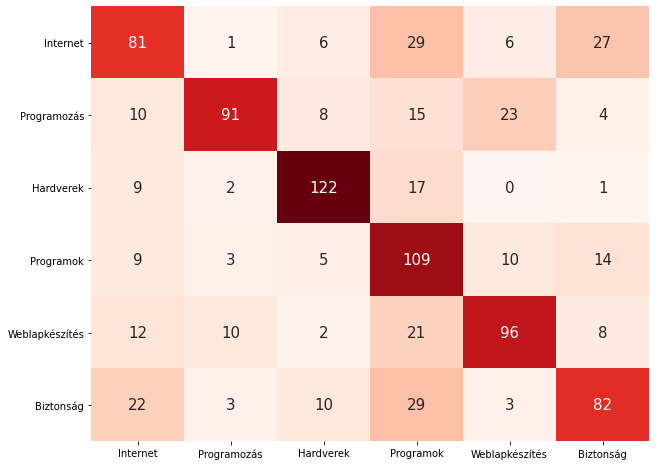

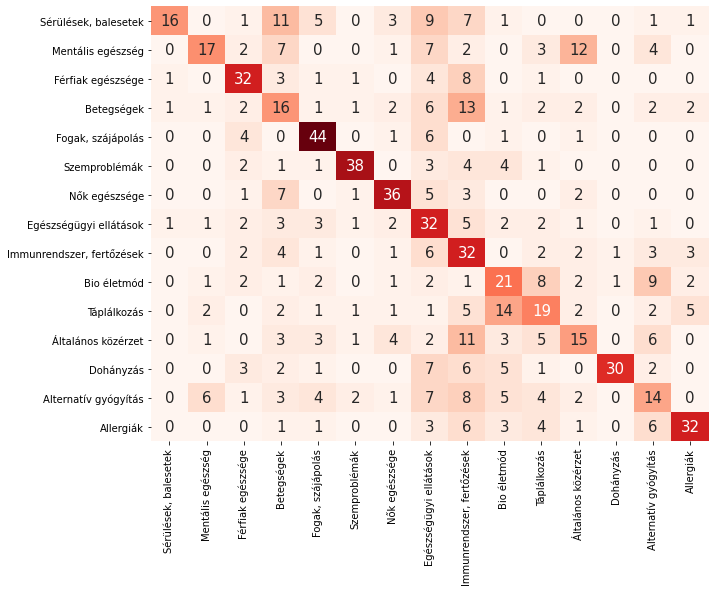

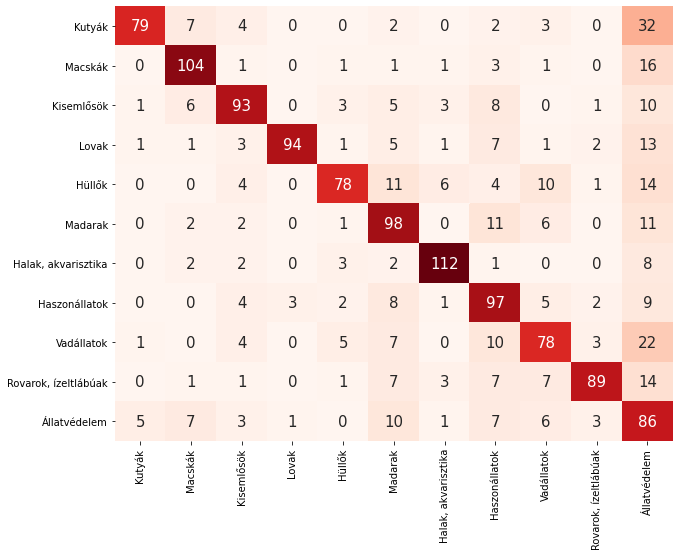

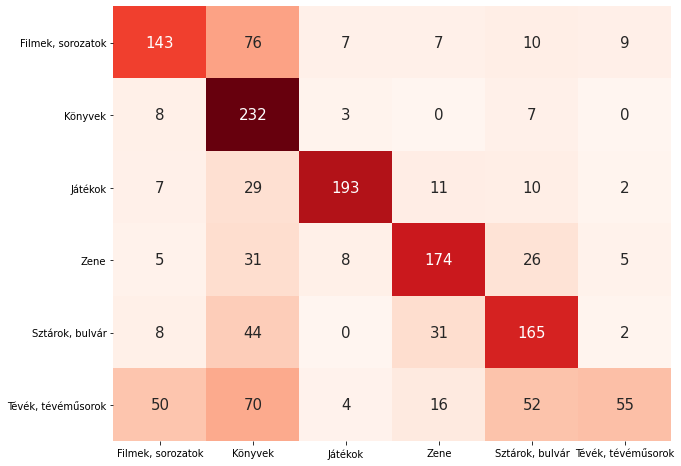

In [33]:
for t in target_names:
    cm = confusion_matrix(test_target_sub[t][0:len(total_pred_sub[t])], total_pred_sub[t])
    cm_df = pd.DataFrame(cm, index=target_names_sub[t], columns=target_names_sub[t])

    plt.figure(figsize = (10,8))
    heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
    plt.show()


In [34]:
for t in target_names:
    class_report = classification_report(test_target_sub[t][0:len(total_pred_sub[t])], total_pred_sub[t], target_names=target_names_sub[t])
    print(class_report)

                precision    recall  f1-score   support

      Internet       0.57      0.54      0.55       150
   Programozás       0.83      0.60      0.70       151
     Hardverek       0.80      0.81      0.80       151
     Programok       0.50      0.73      0.59       150
Weblapkészítés       0.70      0.64      0.67       149
     Biztonság       0.60      0.55      0.58       149

      accuracy                           0.65       900
     macro avg       0.66      0.65      0.65       900
  weighted avg       0.66      0.65      0.65       900

                           precision    recall  f1-score   support

     Sérülések, balesetek       0.84      0.29      0.43        55
        Mentális egészség       0.59      0.31      0.40        55
        Férfiak egészsége       0.59      0.63      0.61        51
               Betegségek       0.25      0.31      0.28        52
        Fogak, szájápolás       0.65      0.77      0.70        57
            Szemproblémák       0.

# Embedding
Get hungarian glove file

In [35]:
download_from_url('https://drive.google.com/uc?id=19k2AACA90Qv1BeUBz8H6trCT4QTJ8OjW', root='.')

'./glove-hu.200k.200d.txt'

In [36]:
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = "glove-hu.200k.200d.txt"
gensim_file = "glove-hu.200k.200d_gensim.txt"

_ = glove2word2vec(glove_file, gensim_file)

In [37]:
embedding = gensim.models.KeyedVectors.load_word2vec_format(gensim_file, binary=False)

## Stemming

In [72]:
from nltk.corpus import stopwords
from nltk.stem.snowball import HungarianStemmer
from nltk.tokenize import RegexpTokenizer
import hu_core_ud_lg

tokenizer = RegexpTokenizer(r'\w+')

stemmer = HungarianStemmer()
q = train_questions[0]

nltk.download('stopwords')
stop_words = set(stopwords.words('hungarian'))

# tokenizálás
tokenized_sentence = tokenizer.tokenize(q)

# stop word szűrés
filtered_sentence = [w for w in tokenized_sentence if not w in stop_words]

# lemmatizáció
nlp = hu_core_ud_lg.load()
doc = nlp(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
print("Eredeti kérdés:")
print(q)

print("\nTokenizálás utáni kérdés:")
for w in tokenized_sentence:
    print(w, end=" ")

print("\n\nStop Word szűrés utáni kérdés:")
for w in filtered_sentence:
    print(w, end=" ")

print("\n\nLemmatizáció utáni kérdés:")
for w in doc:
    print(w.lemma_, end=" ")
    
print("\n\nStemming utáni kérdés:")
for w in tokenized_sentence:
    print(stemmer.stem(w), end=" ")

Eredeti kérdés:
Milyen programot használnak a profi house producerek? (pl. :Robin Schulz, Martin Garrix, DVBBS, Calvin Harris) Inkább big room és deep house érdekel. Használom az fl studio 11-et csak nem annyira tetszik,tudom használni mielőtt valaki azt mondaná hogy azért nem tetszik mert hülye vagyok hozzá.Már probáltam használni más programokat de vagy túl gyengék voltak vagy nem tudtam futtatni a gépemen.(erős gép szóval lehet erre használni.Ahhoz voltam túl hülye hogy futtassam  :) )A válaszokat előre is köszönöm!

Tokenizálás utáni kérdés:
Milyen programot használnak a profi house producerek pl Robin Schulz Martin Garrix DVBBS Calvin Harris Inkább big room és deep house érdekel Használom az fl studio 11 et csak nem annyira tetszik tudom használni mielőtt valaki azt mondaná hogy azért nem tetszik mert hülye vagyok hozzá Már probáltam használni más programokat de vagy túl gyengék voltak vagy nem tudtam futtatni a gépemen erős gép szóval lehet erre használni Ahhoz voltam túl hülye h

In [ ]:
#q = train_df.iloc[0]['Question']

lemmatized_train = []
lemmatized_test = []

stemmed_train = []
stemmed_test = []

lemmatized_filtered_train[]
lemmatized_filtered_test[]

stemmed_filtered_train = []
stemmed_filtered_test = []

In [ ]:
train_df = pd.DataFrame(list(zip(train_target, train_questions)), columns =['Target', 'Question']) 
test_df = pd.DataFrame(list(zip(test_target, test_questions)), columns =['Target', 'Question'])

train_df.to_csv("faq_train.csv", index=False)
test_df.to_csv("faq_test.csv", index = False)